## Imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

### Merge dataframes

In [25]:
# CheXpert+ dataset (without disease labels)
df_cxr_plus = pd.read_csv('/data/df_chexpert_plus_240401.csv')

In [26]:
# Includes disease labels
csv_train='/data/train.csv'
csv_valid='/data/test.csv'

df_train = pd.read_csv(csv_train)
df_valid = pd.read_csv(csv_valid)

In [27]:
diseases = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']
print(f'Number of different diseases: {len(diseases)}')

Number of different diseases: 14


In [28]:
df_train['path_to_image'] = df_train.Path.apply(lambda x: '/'.join(x.split('/')[1:]))
df_valid['path_to_image'] = df_valid.Path.apply(lambda x: '/'.join(x.split('/')[1:]))

df_combined = pd.concat([df_train, df_valid], axis=0)
df_merged = df_cxr_plus.merge(df_combined[['path_to_image'] + diseases], on='path_to_image', how='left')

print(f'Train: {len(df_train)} samples')
print(f'Valid: {len(df_valid)} samples')
print(f'Train and Valid: {len(df_combined)} samples')
print(f'Original CXR+: {len(df_cxr_plus)} samples')
print(f'Merged: {len(df_merged)} samples')

Train: 223414 samples
Valid: 234 samples
Train and Valid: 223648 samples
Original CXR+: 223462 samples
Merged: 223462 samples


## Clean biased variables

In [29]:
biased_columns = ["sex", "age", "race", "health_insurance"]
data_columns = ["path_to_image", "path_to_dcm"]

In [30]:
df_cleaned = df_merged.copy()
print(f'Number of samples before cleaning: {len(df_cleaned)}')

Number of samples before cleaning: 223462


### sex

In [31]:
col = "sex"
df_merged[col].value_counts(dropna=False)

sex
Male       132482
Female      90701
Unknown       279
Name: count, dtype: int64

In [32]:
df_cleaned = df_cleaned[df_cleaned[col] != 'Unknown']
removed_by_sex = len(df_merged) - len(df_cleaned)
print(f' Removed samples with sex = Unknown: {removed_by_sex}')

 Removed samples with sex = Unknown: 279


### race

In [33]:
col = "race"
df_merged[col].value_counts(dropna=False)

race
White               126669
Other                31561
Unknown              25370
Asian                23719
Black                12062
Pacific Islander      3180
Native American        547
Patient Refused        354
Name: count, dtype: int64

In [34]:
df_cleaned = df_cleaned[df_cleaned[col].isin(['White', 'Asian', 'Black'])]
removed_by_race = len(df_merged) - len(df_cleaned) - removed_by_sex
print(f' Removed samples if race not in [White, Asian, Black]: {removed_by_race}')

 Removed samples if race not in [White, Asian, Black]: 60734


### health insurance

In [35]:
col = "insurance_type"
df_merged[col].value_counts(dropna=False)

insurance_type
Medicare             107202
Private Insurance     49074
Unknown               41244
Medicaid              21499
Other                  4443
Name: count, dtype: int64

In [36]:
df_cleaned = df_cleaned[df_cleaned[col].isin(['Medicare', 'Private Insurance', 'Medicaid'])]
removed_by_insurance = len(df_merged) - len(df_cleaned) - removed_by_sex - removed_by_race
print(f' Removed samples if insurance_type not in [Medicare, Private Insurance, Medicaid]: {removed_by_insurance}')

 Removed samples if insurance_type not in [Medicare, Private Insurance, Medicaid]: 29857


### age

Number of nan values: 0


Mean: 62.2779956558465
Median: 64.0
Min: 0.0
Max: 89.0
Number of zeros in Column1: 2


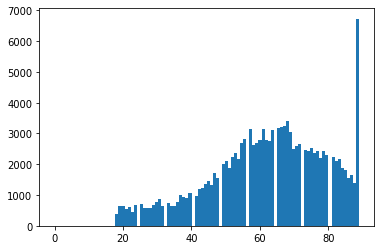

In [37]:
col = "age"
print(f'Number of nan values: {df_cleaned[col].isna().sum()}')

# plot distribution as histogram
plt.hist(df_cleaned[col], bins=100)
np.set_printoptions(suppress=True)

print(f'Mean: {df_cleaned[col].mean()}')
print(f'Median: {df_cleaned[col].median()}')
print(f'Min: {df_cleaned[col].min()}')
print(f'Max: {df_cleaned[col].max()}')

   

## Disease Labels

- **Disease Label = -1**: Disease not present
- **Disease Label = NaN**: Disease not present
- **Disease Label = 0**: Disease not present
- **Disease Label = 1**: Disease present

In [38]:
# value count for each disease
for disease in diseases:
    print(f'{disease}: {df_cleaned[disease].value_counts(dropna=False)}')

No Finding: No Finding
NaN    119058
1.0     13420
0.0       114
Name: count, dtype: int64
Enlarged Cardiomediastinum: Enlarged Cardiomediastinum
 NaN    104665
 0.0     13375
-1.0      7834
 1.0      6718
Name: count, dtype: int64
Cardiomegaly: Cardiomegaly
 NaN    104332
 1.0     16007
 0.0      7166
-1.0      5087
Name: count, dtype: int64
Lung Opacity: Lung Opacity
 1.0    62666
 NaN    62419
 0.0     3966
-1.0     3541
Name: count, dtype: int64
Lung Lesion: Lung Lesion
 NaN    125203
 1.0      5481
 0.0       983
-1.0       925
Name: count, dtype: int64
Edema: Edema
 NaN    83889
 1.0    28322
 0.0    13056
-1.0     7325
Name: count, dtype: int64
Consolidation: Consolidation
 NaN    89739
 0.0    17903
-1.0    16721
 1.0     8229
Name: count, dtype: int64
Pneumonia: Pneumonia
 NaN    116036
-1.0     11146
 1.0      3542
 0.0      1868
Name: count, dtype: int64
Atelectasis: Atelectasis
 NaN    91637
-1.0    20617
 1.0    19404
 0.0      934
Name: count, dtype: int64
Pneumothorax: P

In [39]:
# rename values of disease -1 to 0 and nan to 0
for disease in diseases:
    df_cleaned[disease] = df_cleaned[disease].replace(-1, 0)
    df_cleaned[disease] = df_cleaned[disease].fillna(0)
    df_cleaned[disease] = df_cleaned[disease].astype(int)

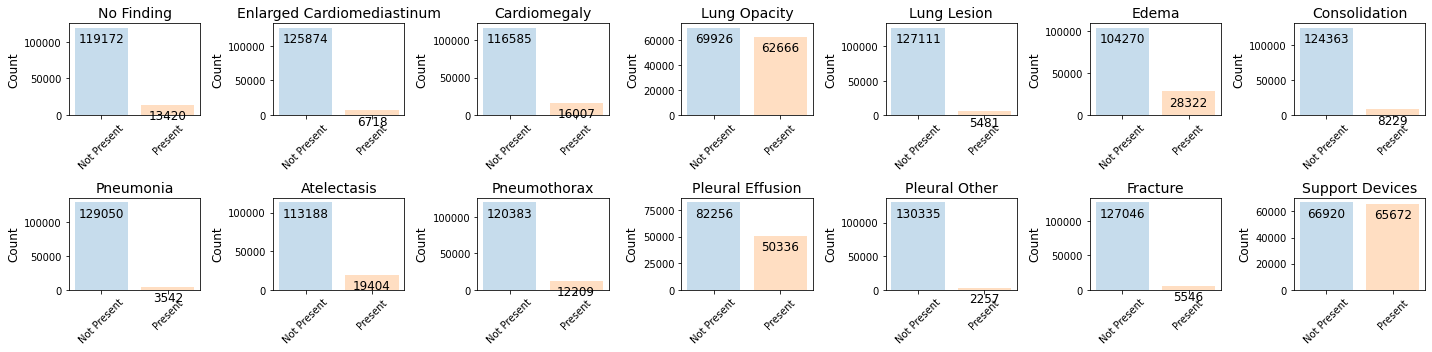

In [40]:
# Create a subplot which shows the count of each disease
fig, ax = plt.subplots(2, 7, figsize=(20, 5))

# Iterate over each disease
for i, disease in enumerate(diseases):
    # Count the occurrences of each label
    counts = df_cleaned[disease].value_counts()
    colors = get_colors(2)
    # Plot bar graph for better visual representation
    bars = ax[i // 7, i % 7].bar(counts.index, counts.values, color=colors)
    
    # Set the title and labels
    ax[i // 7, i % 7].set_title(disease, fontsize=14)
    ax[i // 7, i % 7].set_xticks(counts.index)  # Ensure x-ticks match labels
    ax[i // 7, i % 7].set_xticklabels(['Not Present', 'Present'], rotation=45)
    ax[i // 7, i % 7].set_ylabel('Count', fontsize=12)

    # Add count values inside the bars
    for bar in bars:
        yval = bar.get_height()
        ax[i // 7, i % 7].text(bar.get_x() + bar.get_width() / 2, 
                                yval - (0.05 * max(counts.values)),  # Adjust the height to position inside
                                int(yval), 
                                ha='center', 
                                va='top',  # Align text to the top of the adjusted height
                                fontsize=12,
                                color='black')  

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Remove lateral studies

In [41]:
# get all rows that contain "lateral" in path_to_image
lateral = df_cleaned[df_cleaned['path_to_image'].str.contains('lateral')]
print(f'Number of lateral images: {len(lateral)}')
frontal = df_cleaned[df_cleaned['path_to_image'].str.contains('frontal')]
print(f'Number of frontal images: {len(frontal)}')

removed_by_lateral = len(lateral)

# remove all rows that contain "lateral" in path_to_image
df_cleaned = df_cleaned[~df_cleaned['path_to_image'].str.contains('lateral')]
print(f'Number of samples after removing lateral images: {len(df_cleaned)}')


Number of lateral images: 20487
Number of frontal images: 112105
Number of samples after removing lateral images: 112105


## Save cleaned dataframe

In [42]:
df_cleaned.to_csv('/data/chexpert_plus_240401_cleaned.csv', index=False)

# Overview Removed data 

### Removed by biased value

In [43]:
print(f'Number of samples after cleaning: {len(df_cleaned)}')
print(f' Removed samples by sex: {removed_by_sex}')
print(f' Removed samples by race: {removed_by_race}')
print(f' Removed samples by insurance: {removed_by_insurance}')
print(f' Removed samples by lateral: {removed_by_lateral}')
print(f'Number of removed samples: {len(df_merged) - len(df_cleaned)}')

Number of samples after cleaning: 112105
 Removed samples by sex: 279
 Removed samples by race: 60734
 Removed samples by insurance: 29857
 Removed samples by lateral: 20487
Number of removed samples: 111357
